## **Using EAD, LGD, PD and EL metrics to evaluate credit risk**

### Libraries

In [58]:
import pandas as pd
import numpy as np
from IPython.display import Image
import random

### Sample data

In [59]:
import pandas as pd
import numpy as np


np.random.seed(42)
num_samples = 100

current_exposure = np.random.randint(50, 500, size=num_samples)
credit_limit = current_exposure + np.random.randint(100, 600, size=num_samples)
undrawn_limit = np.maximum(credit_limit - current_exposure, 1)
ccf = np.random.uniform(0, 1, size=num_samples)
drawn_amount = ccf * undrawn_limit
credit_score = np.random.randint(300, 850, size=num_samples)
credit_rating = np.random.choice([1, 2, 3, 4, 5], size=num_samples)  # 1 is best, 5 is worst


data = {
    'current_exposure': current_exposure,
    'limit': credit_limit,
    'ccf': ccf,
    'credit_score': credit_score,
    'credit_rating': credit_rating
}

df = pd.DataFrame(data)

In [60]:
df.head()

,current_exposure,limit,ccf,credit_score,credit_rating
0,152,459,0.929698,460,5
1,485,821,0.808120,697,1
2,398,835,0.633404,576,4
3,320,786,0.871461,803,5
4,156,308,0.803672,691,1


In [61]:
df['utilization_rate'] = df['current_exposure']/df['limit']
df['undrawn_limit'] = df['limit'] - df['current_exposure']

In [62]:
df.head(10)

,current_exposure,limit,ccf,credit_score,credit_rating,utilization_rate,undrawn_limit
0,152,459,0.929698,460,5,0.331155,307
1,485,821,0.808120,697,1,0.590743,336
2,398,835,0.633404,576,4,0.476647,437
3,320,786,0.871461,803,5,0.407125,466
4,156,308,0.803672,691,1,0.506494,152
5,121,500,0.186570,434,2,0.242000,379
6,238,747,0.892559,494,2,0.318608,509
7,70,386,0.539342,700,1,0.181347,316
8,152,503,0.807440,332,2,0.302187,351
9,171,458,0.896091,759,1,0.373362,287


### Calculating EAD

##### Definition: The total value a financial institution is exposed to at the time of a borrower's default.

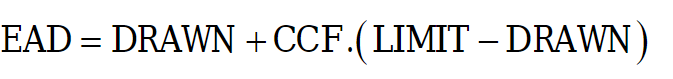

In [63]:
Image("images/ead_formula.png")

##### CCF * (LIMIT - DRAWN) is often referred to as "Adjusted Undrawn Amount" or "Adjusted Undrawn Limit"

In [64]:
df['ead'] = df['current_exposure'] + (df['ccf'] * df['undrawn_limit'])

In [65]:
df.head()

,current_exposure,limit,ccf,credit_score,credit_rating,utilization_rate,undrawn_limit,ead
0,152,459,0.929698,460,5,0.331155,307,437.417179
1,485,821,0.808120,697,1,0.590743,336,756.528448
2,398,835,0.633404,576,4,0.476647,437,674.797442
3,320,786,0.871461,803,5,0.407125,466,726.100635
4,156,308,0.803672,691,1,0.506494,152,278.158156


In [66]:
df = df.map(lambda x: round(x, 2) if isinstance(x, float) else x)

In [67]:
df.head()

,current_exposure,limit,ccf,credit_score,credit_rating,utilization_rate,undrawn_limit,ead
0,152,459,0.93,460,5,0.33,307,437.42
1,485,821,0.81,697,1,0.59,336,756.53
2,398,835,0.63,576,4,0.48,437,674.80
3,320,786,0.87,803,5,0.41,466,726.10
4,156,308,0.80,691,1,0.51,152,278.16


### Calculating LGD (Loss Given Default)

##### Definition: The amount of loss a lender can expect if a borrower defaults on a loan, expressed as a percentage of the total exposure at the time of default

In [68]:
df.shape

(100, 8)

In [80]:
np.min(df['ead'])

np.float64(92.99)

In [81]:
def recovery_amount_simulation(x):
    recovery_amount = np.random.randint(np.min(df['ead']) - 1,x)
    return recovery_amount

In [82]:
df

,current_exposure,limit,ccf,credit_score,credit_rating,utilization_rate,undrawn_limit,ead,recovery_amount,recovery_rate,loss_given_default
0,152,459,0.93,460,5,0.33,307,437.42,159,0.36,0.64
1,485,821,0.81,697,1,0.59,336,756.53,341,0.45,0.55
2,398,835,0.63,576,4,0.48,437,674.80,504,0.75,0.25
3,320,786,0.87,803,5,0.41,466,726.10,534,0.74,0.26
4,156,308,0.80,691,1,0.51,152,278.16,197,0.71,0.29
...,...,...,...,...,...,...,...,...,...,...,...
95,264,690,0.66,405,4,0.38,426,546.65,266,0.49,0.51
96,301,587,0.01,419,1,0.51,286,302.45,100,0.33,0.67
97,239,581,0.16,357,5,0.41,342,294.00,174,0.59,0.41
98,345,530,0.55,645,5,0.65,185,446.52,371,0.83,0.17


In [83]:
df['recovery_amount'] = df['ead'].apply(recovery_amount_simulation)
df['recovery_rate'] = df['recovery_amount'] / df['ead']
df['recovery_rate'] = df['recovery_rate'].apply(lambda x: round(x,2))

df['loss_given_default'] = 1 - df['recovery_rate']

In [84]:
df.head()

,current_exposure,limit,ccf,credit_score,credit_rating,utilization_rate,undrawn_limit,ead,recovery_amount,recovery_rate,loss_given_default
0,152,459,0.93,460,5,0.33,307,437.42,295,0.67,0.33
1,485,821,0.81,697,1,0.59,336,756.53,216,0.29,0.71
2,398,835,0.63,576,4,0.48,437,674.80,133,0.20,0.80
3,320,786,0.87,803,5,0.41,466,726.10,201,0.28,0.72
4,156,308,0.80,691,1,0.51,152,278.16,241,0.87,0.13


### Calculating Expected Loss (EL)

##### In this example, PD was simulated but usually it's calculated based on a logistic regression model

In [93]:
df['probability_of_default'] = [np.round(random.uniform(0.1,0.9),2) for i in range(1,101)]

In [94]:
df

,current_exposure,limit,ccf,credit_score,credit_rating,utilization_rate,undrawn_limit,ead,recovery_amount,recovery_rate,loss_given_default,probability_of_default
0,152,459,0.93,460,5,0.33,307,437.42,295,0.67,0.33,0.16
1,485,821,0.81,697,1,0.59,336,756.53,216,0.29,0.71,0.68
2,398,835,0.63,576,4,0.48,437,674.80,133,0.20,0.80,0.57
3,320,786,0.87,803,5,0.41,466,726.10,201,0.28,0.72,0.78
4,156,308,0.80,691,1,0.51,152,278.16,241,0.87,0.13,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...
95,264,690,0.66,405,4,0.38,426,546.65,201,0.37,0.63,0.79
96,301,587,0.01,419,1,0.51,286,302.45,201,0.66,0.34,0.32
97,239,581,0.16,357,5,0.41,342,294.00,124,0.42,0.58,0.58
98,345,530,0.55,645,5,0.65,185,446.52,201,0.45,0.55,0.66


##### EL = PD * LGD * EAD

In [95]:
df['expected_loss'] = df['probability_of_default'] * df['loss_given_default'] * df['ead']

In [96]:
df['expected_loss'] = df['expected_loss'].apply(lambda x: round(x,2))

In [97]:
df

,current_exposure,limit,ccf,credit_score,credit_rating,utilization_rate,undrawn_limit,ead,recovery_amount,recovery_rate,loss_given_default,probability_of_default,expected_loss
0,152,459,0.93,460,5,0.33,307,437.42,295,0.67,0.33,0.16,23.10
1,485,821,0.81,697,1,0.59,336,756.53,216,0.29,0.71,0.68,365.25
2,398,835,0.63,576,4,0.48,437,674.80,133,0.20,0.80,0.57,307.71
3,320,786,0.87,803,5,0.41,466,726.10,201,0.28,0.72,0.78,407.78
4,156,308,0.80,691,1,0.51,152,278.16,241,0.87,0.13,0.55,19.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,264,690,0.66,405,4,0.38,426,546.65,201,0.37,0.63,0.79,272.07
96,301,587,0.01,419,1,0.51,286,302.45,201,0.66,0.34,0.32,32.91
97,239,581,0.16,357,5,0.41,342,294.00,124,0.42,0.58,0.58,98.90
98,345,530,0.55,645,5,0.65,185,446.52,201,0.45,0.55,0.66,162.09
